# **Capstone Project:** *Intelligent NLP System for Extracting and Structuring Key Information from FDA Regulatory* | Group 2
- Peter Ogunrinde
- Kay Michnicki
- Dominique Fowler

## Imports & Settings

In [80]:
## unzipped the upload dataset folder
#!unzip /content/FDA-Drugs-AdverseEvents.zip

In [3]:
from pathlib import Path
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 160)

# Setting my environment
DATA_ROOT = Path("./FDA-Drugs-AdverseEvents")

AE_DIR      = DATA_ROOT / "fda_adverse_events_recalls" / "adverse_events"
RECALLS_DIR = DATA_ROOT / "fda_adverse_events_recalls" / "recalls"
OUT_DIR     = DATA_ROOT / "fda_adverse_events_recalls" / "adverse_events_recalls_cleaned"
PLOT_DIR    = DATA_ROOT / "adverse_events_recalls_analysis_plots"

OUT_DIR.mkdir(parents=True, exist_ok=True)
PLOT_DIR.mkdir(parents=True, exist_ok=True)

print("Paths:\n", AE_DIR, "\n", RECALLS_DIR, "\n", OUT_DIR)

Paths:
 FDA-Drugs-AdverseEvents/fda_adverse_events_recalls/adverse_events 
 FDA-Drugs-AdverseEvents/fda_adverse_events_recalls/recalls 
 FDA-Drugs-AdverseEvents/fda_adverse_events_recalls/adverse_events_recalls_cleaned


### Load data (robust, no absolute-join mistakes)

In [4]:
def safe_read_csv(p: Path):
    return pd.read_csv(p) if p.exists() else None

drug_csv      = AE_DIR / "drug_adverse_events.csv"
device_csv    = AE_DIR / "device_adverse_events.csv"
biologics_csv = AE_DIR / "biologics_adverse_events.csv"
recalls_csv   = RECALLS_DIR / "recalls.csv"

drug_df      = safe_read_csv(drug_csv)
device_df    = safe_read_csv(device_csv)
biologics_df = safe_read_csv(biologics_csv)
recalls_df   = safe_read_csv(recalls_csv)

for name, df in dict(drug=drug_df, device=device_df, biologics=biologics_df, recalls=recalls_df).items():
    print(f"{name:>9}: {0 if df is None else len(df):,} rows")

     drug: 1,000 rows
   device: 1,000 rows
biologics: 51 rows
  recalls: 2,000 rows


### Shared helpers

In [5]:
def parse_ymd_int(series: pd.Series, colname="date"):
    """
    Parse integer YYYYMMDD safely (fixes earlier 1970 epoch bug).
    """
    # Keep only 8-digit yyyymmdd-like values
    s = pd.to_numeric(series, errors="coerce").astype("Int64")
    return pd.to_datetime(s.astype("string"), format="%Y%m%d", errors="coerce")

def clean_sex_to_MF(series: pd.Series):
    """
    Map 1/2 types and text to M/F; 0/unknown -> NaN.
    """
    s = series.astype(str).str.strip().str.upper()
    s = s.replace({"1": "M", "1.0": "M", "M": "M", "MALE": "M",
                   "2": "F", "2.0": "F", "F": "F", "FEMALE": "F",
                   "0": np.nan, "0.0": np.nan, "": np.nan, "NAN": np.nan, "NONE": np.nan})
    return s

def split_reactions(series: pd.Series):
    all_rx = []
    for val in series.fillna(""):
        items = [x.strip() for x in str(val).split(",") if x.strip()]
        all_rx.extend(items)
    return Counter(all_rx)

def title_or_nan(series: pd.Series):
    # Keep pure NaNs as NaN (avoid "Nan" string)
    s = series.astype("string")
    s = s.mask(s.str.strip().isin([None, "", "NAN", "NaN", "nan"]), other=np.nan)
    return s.dropna().str.title().reindex(series.index, fill_value=np.nan)

### Clean: DRUG adverse events

In [6]:
drug_clean = None
if drug_df is not None and len(drug_df):
    dc = drug_df.copy()

    # Dates (fixes 1970 bug)
    dc["receivedate_parsed"] = parse_ymd_int(dc["receivedate"])
    dc["year"] = dc["receivedate_parsed"].dt.year

    # Names & reactions
    dc["drug_product_name_cleaned"] = title_or_nan(dc["drug_product_name"])
    dc["drug_generic_name_cleaned"] = title_or_nan(dc.get("drug_generic_name", pd.Series(index=dc.index)))

    ar = dc["adverse_reactions"].astype(str).str.replace(",", ", ", regex=False)
    ar = ar.str.replace(r"\s+", " ", regex=True).str.strip().replace({"": np.nan, "nan": np.nan})
    dc["adverse_reactions_cleaned"] = ar

    # Serious (compare to INT! fixes 0% rate)
    # In FAERS extracts, serious often 1=serious, 2=non-serious
    dc["serious_binary"] = (pd.to_numeric(dc["serious"], errors="coerce") == 1).astype("Int64")

    # Demographics
    dc["patient_age_numeric"] = pd.to_numeric(dc.get("patient_age", np.nan), errors="coerce").clip(0, 120)
    dc["patient_sex_clean"] = clean_sex_to_MF(dc.get("patient_sex", np.nan))

    # Dedupe
    subset_cols = [c for c in ["safetyreportid"] if c in dc.columns]
    if subset_cols:
        dc = dc.drop_duplicates(subset=subset_cols, keep="first")

    # Quality flags
    dc["has_drug_name"] = dc["drug_product_name_cleaned"].notna()
    dc["has_reaction"]  = dc["adverse_reactions_cleaned"].notna()
    dc["has_date"]      = dc["receivedate_parsed"].notna()
    dc["quality_score"] = (dc["has_drug_name"].astype(int) + dc["has_reaction"].astype(int) + dc["has_date"].astype(int)) / 3

    drug_clean = dc
    print("Drug cleaned:", drug_clean.shape)
else:
    print("No drug data")

Drug cleaned: (1000, 29)


#### Clean: DEVICE adverse events

In [8]:
device_clean = None
if device_df is not None and len(device_df):
    dd = device_df.copy()

    # Parse report date
    dd["report_date_parsed"] = parse_ymd_int(dd["report_date"])
    dd["report_year"] = dd["report_date_parsed"].dt.year

    # Keep missing device_name as NaN (avoid "Nan" string)
    dd["device_name_cleaned"] = title_or_nan(dd.get("device_name", pd.Series(index=dd.index)))

    # to salvage a device name from raw_data JSON (best-effort)
    def try_extract_name(row):
        raw = row.get("raw_data", None)
        if pd.isna(raw): return np.nan
        try:
            obj = json.loads(raw)
            # heuristic keys frequently seen in MAUDE-like payloads
            for k in ["device_name", "devicebrandname", "brand_name", "generic_name"]:
                if k in obj and str(obj[k]).strip():
                    return str(obj[k]).strip().title()
        except Exception:
            return np.nan
        return np.nan

    # Only fill missing
    if "raw_data" in dd.columns:
        fill = dd.apply(lambda r: try_extract_name(r) if pd.isna(r["device_name_cleaned"]) else r["device_name_cleaned"], axis=1)
        dd["device_name_cleaned"] = fill

    # Normalize flags
    for col in ["event_type", "adverse_event_flag", "product_problem_flag"]:
        if col in dd.columns:
            dd[col] = dd[col].astype("string").str.strip()

    # NOTE: Do not dedup on safetyreportid (not present here)
    device_clean = dd
    print("Device cleaned:", device_clean.shape)
else:
    print("No device data")

Device cleaned: (1000, 14)


#### Clean: BIOLOGICS adverse events

In [9]:
biologics_clean = None
if biologics_df is not None and len(biologics_df):
    bc = biologics_df.copy()

    bc["receivedate_parsed"] = parse_ymd_int(bc["receivedate"])
    bc["year"] = bc["receivedate_parsed"].dt.year

    bc["biologics_product_name_cleaned"] = title_or_nan(bc["biologics_product_name"])
    bc["biologics_brand_name_cleaned"]   = title_or_nan(bc.get("biologics_brand_name", pd.Series(index=bc.index)))

    ar = bc["adverse_reactions"].astype(str).str.replace(",", ", ", regex=False)
    ar = ar.str.replace(r"\s+", " ", regex=True).str.strip().replace({"": np.nan, "nan": np.nan})
    bc["adverse_reactions_cleaned"] = ar

    bc["serious_binary"] = (pd.to_numeric(bc["serious"], errors="coerce") == 1).astype("Int64")
    bc["patient_age_numeric"] = pd.to_numeric(bc.get("patient_age", np.nan), errors="coerce").clip(0, 120)
    bc["patient_sex_clean"] = clean_sex_to_MF(bc.get("patient_sex", np.nan))

    # Dedupe if safetyreportid exists
    if "safetyreportid" in bc.columns:
        bc = bc.drop_duplicates(subset=["safetyreportid"], keep="first")

    # Quality flags
    bc["has_product_name"] = bc["biologics_product_name_cleaned"].notna()
    bc["has_reaction"]     = bc["adverse_reactions_cleaned"].notna()
    bc["has_date"]         = bc["receivedate_parsed"].notna()
    bc["quality_score"]    = (bc["has_product_name"].astype(int) + bc["has_reaction"].astype(int) + bc["has_date"].astype(int)) / 3

    biologics_clean = bc
    print("Biologics cleaned:", biologics_clean.shape)
else:
    print("No biologics data")

Biologics cleaned: (51, 26)


#### Clean: RECALLS

In [10]:
recalls_clean = None
if recalls_df is not None and len(recalls_df):
    rc = recalls_df.copy()

    # Normalize product / reason fields
    for c in [c for c in rc.columns if "product" in c.lower() or "name" in c.lower()]:
        rc[c] = rc[c].astype("string").str.strip().replace({"": np.nan})

    if "reason_for_recall" in rc.columns:
        rc["reason_for_recall"] = rc["reason_for_recall"].astype("string").str.strip().replace({"": np.nan, "nan": np.nan})

    # Dates
    rc["recall_initiation_date_parsed"] = parse_ymd_int(rc["recall_initiation_date"])
    rc["year"]  = rc["recall_initiation_date_parsed"].dt.year
    rc["month"] = rc["recall_initiation_date_parsed"].dt.month

    # Dedupe by recall_number if present
    if "recall_number" in rc.columns:
        rc = rc.drop_duplicates(subset=["recall_number"], keep="first")

    # Quality score
    has_prod = pd.Series(False, index=rc.index)
    for c in [c for c in rc.columns if "product" in c.lower() or "name" in c.lower()]:
        has_prod |= rc[c].notna()

    rc["has_reason"] = rc["reason_for_recall"].notna() if "reason_for_recall" in rc.columns else False
    rc["has_product"] = has_prod
    rc["has_date"] = rc["recall_initiation_date_parsed"].notna()
    rc["quality_score"] = (rc["has_reason"].astype(int) + rc["has_product"].astype(int) + rc["has_date"].astype(int)) / 3

    recalls_clean = rc
    print("Recalls cleaned:", recalls_clean.shape)
else:
    print("No recalls data")

Recalls cleaned: (2000, 15)


#### Quick sanity checks that fix prior misreads

In [11]:
if drug_clean is not None:
    serious_rate = (drug_clean["serious_binary"] == 1).mean() * 100
    print(f"Drug serious rate (1=serious): {serious_rate:.2f}%")  # should no longer be 0%

    print("Drug year span:", drug_clean["receivedate_parsed"].min(), "-->", drug_clean["receivedate_parsed"].max())

if device_clean is not None:
    print("Device unique names (non-null):", device_clean["device_name_cleaned"].dropna().nunique())

if recalls_clean is not None:
    print("Recalls year span:", recalls_clean["recall_initiation_date_parsed"].min(), "-->", recalls_clean["recall_initiation_date_parsed"].max())

Drug serious rate (1=serious): 45.40%
Drug year span: 2008-07-07 00:00:00 --> 2014-03-12 00:00:00
Device unique names (non-null): 0
Recalls year span: 2005-12-27 00:00:00 --> 2025-09-19 00:00:00


#### Minimal plots (safe + readable)

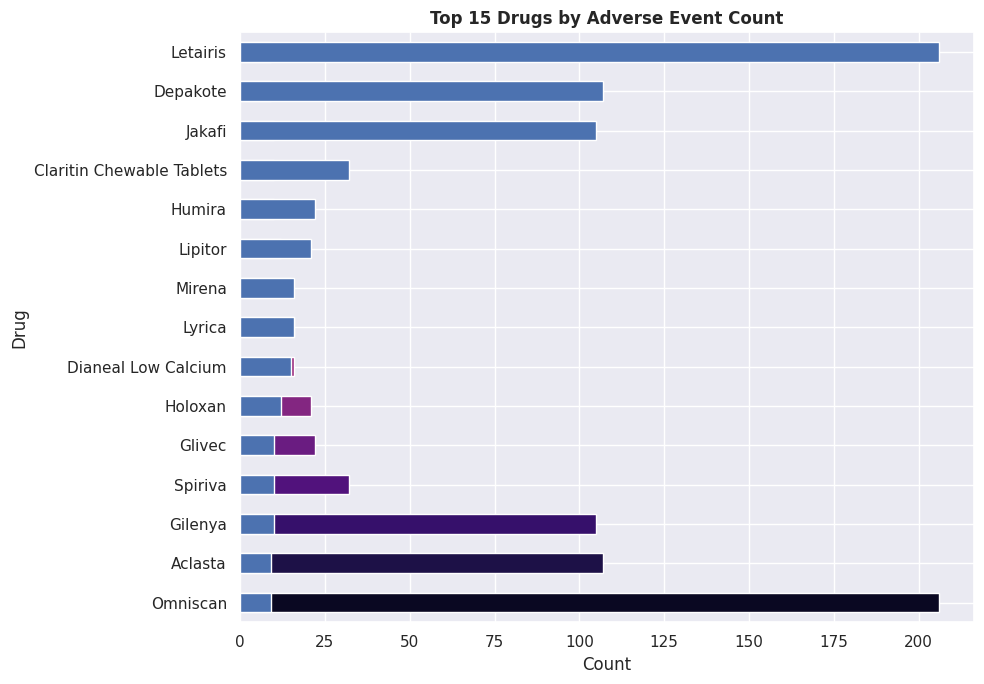

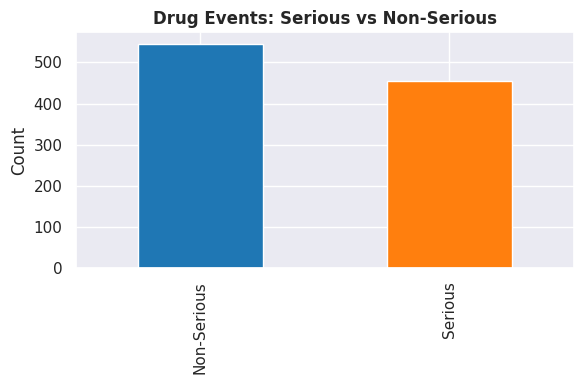

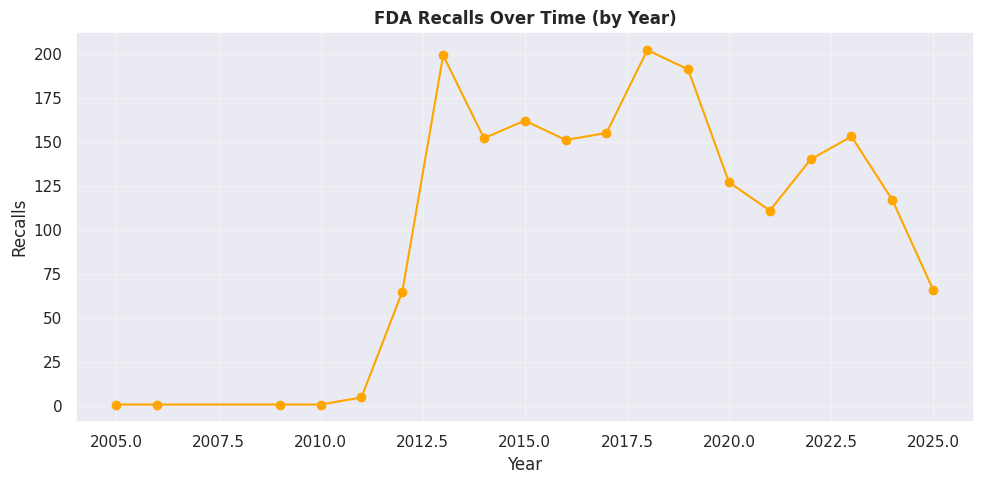

In [12]:
sns.set_theme()

if drug_clean is not None and drug_clean["drug_product_name_cleaned"].notna().any():
    top = drug_clean["drug_product_name_cleaned"].value_counts().head(15)
    top.plot(kind='barh', color=sns.color_palette('magma', len(top)))
    ax = top.sort_values().plot(kind="barh", figsize=(10,7))
    ax.set_title("Top 15 Drugs by Adverse Event Count", fontsize=12, fontweight='bold'); ax.set_xlabel("Count"); ax.set_ylabel("Drug")
    plt.tight_layout(); plt.show()

if drug_clean is not None and "serious_binary" in drug_clean.columns:
    ser_counts = drug_clean["serious_binary"].value_counts(dropna=False).rename({0:"Non-Serious",1:"Serious", pd.NA:"Unknown"})
    ax = ser_counts.plot(kind="bar", color=sns.color_palette('tab10', len(ser_counts)), figsize=(6,4))
    ax.set_title("Drug Events: Serious vs Non-Serious", fontsize=12, fontweight='bold'); ax.set_xlabel(""); ax.set_ylabel("Count")
    plt.tight_layout(); plt.show()

if recalls_clean is not None and "year" in recalls_clean.columns:
    yearly = recalls_clean["year"].value_counts().sort_index()
    ax = yearly.plot(kind="line", marker="o", figsize=(10,5) , color='orange')
    ax.set_title("FDA Recalls Over Time (by Year)",fontsize=12, fontweight='bold'); ax.set_xlabel("Year"); ax.set_ylabel("Recalls")
    plt.grid(alpha=.3); plt.tight_layout(); plt.show()

### Save cleaned datasets

In [13]:
def save(df: pd.DataFrame, name: str):
    if df is None: return
    df.to_parquet(OUT_DIR / f"{name}.parquet", index=False)
    df.to_csv(OUT_DIR / f"{name}.csv", index=False)
    print("Saved:", name)

save(drug_clean, "drug_adverse_events_cleaned")
save(device_clean, "device_adverse_events_cleaned")
save(biologics_clean, "biologics_adverse_events_cleaned")
save(recalls_clean, "recalls_cleaned")

Saved: drug_adverse_events_cleaned
Saved: device_adverse_events_cleaned
Saved: biologics_adverse_events_cleaned
Saved: recalls_cleaned


## EDA (brief results)

- **Rows** - drug: **1,000**, device: **1,000**, biologics: **51**, recalls: **2,000**.

- Fixes applied - correct YYYYMMDD parsing; serious_binary cast from int (fixes prior 0% issue); text cleaned; device names preserved as true NaN (no "Nan"); quality flags; deduping where keys exist.


***Spans / sanity***

- Drug dates: 2008-07-07 --> 2014-03-12
- Recalls dates: 2005-12-27 --> 2025-09-19
- Drug serious rate: **45.40%**
- Device unique names (non-null): 0 (source limitation)

**Saved to** .../adverse_events_recalls_cleaned/*.parquet and *.csv.

---

# Model Design/Building

### Imports & Global Config

In [14]:
# MODEL DESIGN / BUILDING — BASELINES (SKLEARN)

# Goals:
# A) DRUG_SERIOUS: Predict serious (1) vs non-serious (0)
# B) RECALL_CLASS: Predict recall class (I/II/III)

# Design choices:
# - Regularized linear baselines (LogReg, LinearSVC) with TF-IDF
# - Robust preprocessing: text + small tabular features
# - Stratified splits, 5-fold CV grid search
# - Save best pipelines for reuse

#Imports, paths, helpers
from pathlib import Path
import re, json, itertools
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.impute import SimpleImputer
import joblib

RANDOM_STATE = 42
pd.set_option("display.max_colwidth", 120)

# Match the EDA layout
DATA_ROOT = Path("./FDA-Drugs-AdverseEvents")
CLEAN_DIR = DATA_ROOT / "fda_adverse_events_recalls" / "adverse_events_recalls_cleaned"
MODEL_DIR = DATA_ROOT / "fda_adverse_events_recalls" / "models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

print("Clean dir:", CLEAN_DIR.resolve())
print("Model dir:", MODEL_DIR.resolve())

def load_clean(name: str):
    pq = CLEAN_DIR / f"{name}.parquet"
    cs = CLEAN_DIR / f"{name}.csv"
    if pq.exists():
        df = pd.read_parquet(pq); print(f"Loaded {name} (parquet):", df.shape); return df
    if cs.exists():
        df = pd.read_csv(cs);     print(f"Loaded {name} (csv):", df.shape);     return df
    print(f"[WARN] Missing cleaned file: {name}")
    return None

def clean_text(s: pd.Series) -> pd.Series:
    s = s.astype("string").fillna("")
    return s.str.replace(r"\s+", " ", regex=True).str.strip()

def show_class_balance(y, title="Class balance"):
    vc = pd.Series(y).value_counts(dropna=False).sort_index()
    print(f"\n{title}:\n{vc.to_string()}")
    if len(vc) and vc.min() < 20:
        print("NOTE: at least one class has <20 samples; metrics may be noisy.")

Clean dir: /content/FDA-Drugs-AdverseEvents/fda_adverse_events_recalls/adverse_events_recalls_cleaned
Model dir: /content/FDA-Drugs-AdverseEvents/fda_adverse_events_recalls/models


### Helper loaders & utilities

In [15]:
# Load cleaned datasets (created in EDA step)
# Fallback: if parquet not available, try csv.
def load_clean(name: str):
    pq = CLEAN_DIR / f"{name}.parquet"
    cs = CLEAN_DIR / f"{name}.csv"
    if pq.exists():
        df = pd.read_parquet(pq); print(f"Loaded {name} (parquet):", df.shape);
        return df
    if cs.exists():
        df = pd.read_csv(cs);     print(f"Loaded {name} (csv):", df.shape);
        return df
    print(f"[WARN] Missing cleaned file: {name}")
    return None

def clean_text(s: pd.Series) -> pd.Series:
    s = s.astype("string").fillna("")
    return s.str.replace(r"\s+", " ", regex=True).str.strip()

def show_class_balance(y, title="Class balance"):
    vc = pd.Series(y).value_counts(dropna=False).sort_index()
    print(f"\n{title}:\n{vc.to_string()}")
    if len(vc) and vc.min() < 20:
        print("NOTE: One or more classes are small; metrics may be noisy.")

drug = load_clean("drug_adverse_events_cleaned")
reca = load_clean("recalls_cleaned")

Loaded drug_adverse_events_cleaned (parquet): (1000, 29)
Loaded recalls_cleaned (parquet): (2000, 15)



**Drug Adverse Events: Predict** serious_binary

**Goal**: To build a baseline classifier that uses text + simple tabular features.

**Features:**
- **Text**: adverse_reactions_cleaned + drug names (concatenated)
- **Numeric**: patient_age_numeric
- **Categorical**: patient_sex_clean (M/F)
- **Target**: serious_binary (drop NaNs)

### Build training frame for DRUG model: Drug Adverse Events - predict serious_binary

In [17]:
# DRUG_SERIOUS baseline
if drug is not None and len(drug):
    df = drug.copy()
    df = df[df["serious_binary"].notna()].copy()
    df["serious_binary"] = df["serious_binary"].astype(int)

    # Text: reactions + product names
    for col in ["adverse_reactions_cleaned","drug_product_name_cleaned","drug_generic_name_cleaned"]:
        if col not in df.columns: df[col] = ""
    df["txt"] = clean_text(
        df["adverse_reactions_cleaned"].fillna("") + " " +
        df["drug_product_name_cleaned"].fillna("") + " " +
        df["drug_generic_name_cleaned"].fillna("")
    )

    # Tabular: age & sex
    if "patient_age_numeric" not in df.columns: df["patient_age_numeric"] = np.nan
    df["patient_age_numeric"] = pd.to_numeric(df["patient_age_numeric"], errors="coerce").clip(0, 120)
    if "patient_sex_clean" not in df.columns: df["patient_sex_clean"] = np.nan

    X = df[["txt","patient_age_numeric","patient_sex_clean"]].copy()
    y = df["serious_binary"].copy()

    print("DRUG frame:", X.shape, "target:", y.shape)
    show_class_balance(y, "DRUG: Serious (1) vs Non-Serious (0)")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
    )
    print("Train/Test:", X_train.shape, X_test.shape)

    # Preprocess + Logistic Regression
    preproc = ColumnTransformer(
        transformers=[
            ("txt", TfidfVectorizer(lowercase=True, ngram_range=(1,2), min_df=3, max_df=0.95, sublinear_tf=True), "txt"),
            ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                              ("sc", StandardScaler(with_mean=False))]), ["patient_age_numeric"]),
            ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                              ("oh",  OneHotEncoder(handle_unknown="ignore"))]), ["patient_sex_clean"]),
        ],
        remainder="drop",
        verbose_feature_names_out=False
    )

    pipe_lr = Pipeline([
        ("prep", preproc),
        ("clf", LogisticRegression(max_iter=200, class_weight="balanced",
                                   solver="liblinear", random_state=RANDOM_STATE))
    ])

    grid_lr = GridSearchCV(
        pipe_lr,
        param_grid={"clf__C":[0.25,0.5,1.0,2.0], "clf__penalty":["l1","l2"]},
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
        n_jobs=-1, scoring="f1"
    )
    grid_lr.fit(X_train, y_train)

    print("Best LR params:", grid_lr.best_params_)
    print("CV best F1:", grid_lr.best_score_)
    y_pred = grid_lr.predict(X_test)
    if hasattr(grid_lr.best_estimator_["clf"], "predict_proba"):
        y_proba = grid_lr.predict_proba(X_test)[:,1]
        print("Test ROC-AUC:", round(roc_auc_score(y_test, y_proba), 4))
    print("\nClassification Report (LR):\n", classification_report(y_test, y_pred, digits=3))
    print("Confusion Matrix (LR):\n", confusion_matrix(y_test, y_pred))

    # Save LR pipeline
    joblib.dump(grid_lr.best_estimator_, MODEL_DIR / "drug_serious_lr.joblib")
    print("Saved ->", (MODEL_DIR / "drug_serious_lr.joblib").name)

    # Alternative: Linear SVM
    pipe_svm = Pipeline([
        ("prep", preproc),
        ("clf", LinearSVC(class_weight="balanced", random_state=RANDOM_STATE))
    ])
    grid_svm = GridSearchCV(pipe_svm, param_grid={"clf__C":[0.5,1.0,2.0]},
                            cv=5, n_jobs=-1, scoring="f1")
    grid_svm.fit(X_train, y_train)
    print("\nBest SVM params:", grid_svm.best_params_)
    print("CV best F1 (SVM):", grid_svm.best_score_)
    y_pred_svm = grid_svm.predict(X_test)
    print("\nClassification Report (SVM):\n", classification_report(y_test, y_pred_svm, digits=3))
    print("Confusion Matrix (SVM):\n", confusion_matrix(y_test, y_pred_svm))

    joblib.dump(grid_svm.best_estimator_, MODEL_DIR / "drug_serious_svm.joblib")
    print("Saved ->", (MODEL_DIR / "drug_serious_svm.joblib").name)
else:
    print("[SKIP] No drug data.")

DRUG frame: (1000, 3) target: (1000,)

DRUG: Serious (1) vs Non-Serious (0):
serious_binary
0    546
1    454
Train/Test: (800, 3) (200, 3)
Best LR params: {'clf__C': 2.0, 'clf__penalty': 'l1'}
CV best F1: 0.8544871638886622
Test ROC-AUC: 0.9486

Classification Report (LR):
               precision    recall  f1-score   support

           0      0.881     0.881     0.881       109
           1      0.857     0.857     0.857        91

    accuracy                          0.870       200
   macro avg      0.869     0.869     0.869       200
weighted avg      0.870     0.870     0.870       200

Confusion Matrix (LR):
 [[96 13]
 [13 78]]
Saved -> drug_serious_lr.joblib

Best SVM params: {'clf__C': 0.5}
CV best F1 (SVM): 0.8420136153065177

Classification Report (SVM):
               precision    recall  f1-score   support

           0      0.887     0.936     0.911       109
           1      0.918     0.857     0.886        91

    accuracy                          0.900       200
  

### Recalls: extract class from raw_data --> train classifier
- Extract classification from nested JSON then map to {1,2,3}

In [18]:
# RECALL_CLASS - label extraction
if reca is not None and len(reca):
    df_r = reca.copy()

    # Normalize headers (strip + lowercase) to make lookups robust
    norm = {c: re.sub(r"\s+", " ", c).strip().lower() for c in df_r.columns}
    df_r.rename(columns=norm, inplace=True)
    print("\n[Recalls] Columns:", list(df_r.columns))

    # pull 'classification' from raw_data JSON
    def find_classification(obj):
        """Recursively find likely class keys in nested dict/list."""
        KEYS = {"classification", "recall_class", "class",
                "recall_classification", "classification_type"}
        if isinstance(obj, dict):
            for k, v in obj.items():
                kl = re.sub(r"\s+", " ", str(k)).strip().lower().replace(" ", "_")
                if kl in KEYS:
                    return str(v)
            # search deeper
            for v in obj.values():
                got = find_classification(v)
                if got is not None: return got
        elif isinstance(obj, list):
            for it in obj:
                got = find_classification(it)
                if got is not None: return got
        return None

    def extract_class_from_raw(txt):
        if pd.isna(txt): return np.nan
        try:
            obj = json.loads(txt)
        except Exception:
            return np.nan
        return find_classification(obj)

    if "raw_data" in df_r.columns:
        df_r["class_from_raw"] = df_r["raw_data"].apply(extract_class_from_raw)
    else:
        df_r["class_from_raw"] = np.nan

    print("\n[class_from_raw] examples:")
    display(df_r.loc[df_r["class_from_raw"].notna(), ["class_from_raw"]].head(10))
    print("Non-null count:", int(df_r["class_from_raw"].notna().sum()), "/", len(df_r))

    # map 'Class I/II/III' --> {1,2,3}; with fallback from reason text
    def map_class_label(v):
        if pd.isna(v): return np.nan
        s = str(v).upper().strip()
        if re.search(r"\bCLASS\s*I\b|\bCLASS\s*1\b|^I$", s):   return 1
        if re.search(r"\bCLASS\s*II\b|\bCLASS\s*2\b|^II$", s): return 2
        if re.search(r"\bCLASS\s*III\b|\bCLASS\s*3\b|^III$", s): return 3
        return np.nan

    df_r["recall_class_num"] = df_r["class_from_raw"].map(map_class_label)

    # Fallback: sometimes reason text has the class string too
    if "reason_for_recall" in df_r.columns:
        def infer_from_reason(txt):
            if pd.isna(txt): return np.nan
            s = str(txt).upper()
            if "CLASS I"   in s: return 1
            if "CLASS II"  in s: return 2
            if "CLASS III" in s: return 3
            return np.nan
        df_r["recall_class_num"] = df_r["recall_class_num"].fillna(
            df_r["reason_for_recall"].apply(infer_from_reason)
        )

    print("\nClass counts (after JSON + fallback):")
    print(df_r["recall_class_num"].value_counts(dropna=False).sort_index())

else:
    df_r = None
    print("[SKIP] No recalls data.")


[Recalls] Columns: ['recall_number', 'recall_initiation_date', 'product_description', 'reason_for_recall', 'product_type', 'recalling_firm', 'status', 'raw_data', 'recall_initiation_date_parsed', 'year', 'month', 'has_reason', 'has_product', 'has_date', 'quality_score']

[class_from_raw] examples:


,class_from_raw
0,Class II
1,Class II
2,Class II
3,Class II
4,Class II
5,Class III
6,Class II
7,Class II
8,Class II
9,Class II


Non-null count: 2000 / 2000

Class counts (after JSON + fallback):
recall_class_num
1     211
2    1675
3     114
Name: count, dtype: int64


#### Train Recalls classifier (robust TF-IDF with fallback)

In [37]:
# RECALL_CLASS - model training
if df_r is not None:
    # Which classes are actually present?
    present = sorted(
        [int(x) for x in df_r["recall_class_num"].dropna().unique()]
    ) if df_r["recall_class_num"].notna().any() else []
    print("\nPresent classes:", present)

    if len(present) >= 2 and "reason_for_recall" in df_r.columns:
        # Build training frame (Xr, yr)
        Xr = df_r.loc[df_r["recall_class_num"].notna(),
                      ["reason_for_recall"]].copy()
        yr = df_r.loc[df_r["recall_class_num"].notna(),
                      "recall_class_num"].astype(int).copy()

        # Light text cleaning and drop completely empty reasons
        Xr["reason_for_recall"] = clean_text(Xr["reason_for_recall"])
        empty_n = int((Xr["reason_for_recall"].str.len() == 0).sum())
        if empty_n:
            print(f"[INFO] Dropping {empty_n} empty reason texts.")
            keep = Xr["reason_for_recall"].str.len() > 0
            Xr, yr = Xr.loc[keep], yr.loc[keep]

        # Train/test split (stratified)
        Xr_train, Xr_test, yr_train, yr_test = train_test_split(
            Xr, yr, test_size=0.20,
            random_state=RANDOM_STATE, stratify=yr
        )
        print("Recalls Train/Test:", Xr_train.shape, Xr_test.shape)

        # Logistic Regression with empty-vocabulary guard
        def build_recalls_lr_pipe(min_df=3):
            """Builds the LR pipeline for recalls with a TF-IDF block."""
            pre_r = ColumnTransformer(
                transformers=[
                    ("txt",
                     TfidfVectorizer(lowercase=True,
                                     ngram_range=(1, 2),
                                     min_df=min_df,
                                     max_df=0.95,
                                     sublinear_tf=True),
                     "reason_for_recall")
                ],
                remainder="drop"
            )
            pipe_r = Pipeline([
                ("prep", pre_r),
                ("clf", LogisticRegression(
                    max_iter=300,
                    multi_class="ovr",
                    class_weight="balanced",
                    solver="liblinear",
                    random_state=RANDOM_STATE,
                )),
            ])
            return pipe_r

        # First try with min_df=3
        pipe_r = build_recalls_lr_pipe(min_df=3)
        grid_r = GridSearchCV(
            pipe_r,
            param_grid={"clf__C": [0.5, 1.0, 2.0]},
            cv=5,
            n_jobs=-1,
            scoring="f1_macro",
        )

        try:
            grid_r.fit(Xr_train, yr_train)
        except ValueError as e:
            # "empty vocabulary" for some CV fold
            if "empty vocabulary" in str(e).lower():
                print("[WARN] Empty vocabulary on some folds; "
                      "retrying with min_df=1.")
                pipe_r = build_recalls_lr_pipe(min_df=1)
                grid_r = GridSearchCV(
                    pipe_r,
                    param_grid={"clf__C": [0.5, 1.0, 2.0]},
                    cv=5,
                    n_jobs=-1,
                    scoring="f1_macro",
                )
                grid_r.fit(Xr_train, yr_train)
            else:
                raise

        print("Best Recalls LR params:", grid_r.best_params_)
        print("CV best F1_macro (LR):", grid_r.best_score_)
        yr_pred_lr = grid_r.predict(Xr_test)
        print("\nClassification Report (Recalls LR):\n",
              classification_report(yr_test, yr_pred_lr, digits=3))
        print("Confusion Matrix (Recalls LR):\n",
              confusion_matrix(yr_test, yr_pred_lr))


        # Linear SVM (this creates grid_svm_r)
        pre_r_svm = ColumnTransformer(
            transformers=[
                ("txt",
                 TfidfVectorizer(lowercase=True,
                                 ngram_range=(1, 2),
                                 min_df=1,        # tolerant to rare terms
                                 max_df=0.95,
                                 sublinear_tf=True),
                 "reason_for_recall")
            ],
            remainder="drop"
        )

        pipe_svm_r = Pipeline([
            ("prep", pre_r_svm),
            ("clf", LinearSVC(
                class_weight="balanced",
                random_state=RANDOM_STATE,
            )),
        ])

        grid_svm_r = GridSearchCV(
            pipe_svm_r,
            param_grid={"clf__C": [0.25, 0.5, 1.0, 2.0]},
            cv=5,
            n_jobs=-1,
            scoring="f1_macro",
        )
        grid_svm_r.fit(Xr_train, yr_train)

        print("\nBest Recalls SVM params:", grid_svm_r.best_params_)
        print("CV best F1_macro (SVM):", grid_svm_r.best_score_)
        yr_pred_svm = grid_svm_r.predict(Xr_test)
        print("\nClassification Report (Recalls SVM):\n",
              classification_report(yr_test, yr_pred_svm, digits=3))
        print("Confusion Matrix (Recalls SVM):\n",
              confusion_matrix(yr_test, yr_pred_svm))

        # Save both recalls models to the models folder
        joblib.dump(grid_r.best_estimator_,
                    MODEL_DIR / "recalls_class_lr.joblib")
        joblib.dump(grid_svm_r.best_estimator_,
                    MODEL_DIR / "recalls_class_svm.joblib")

        print("Saved -->", (MODEL_DIR / "recalls_class_lr.joblib").name)
        print("Saved -->", (MODEL_DIR / "recalls_class_svm.joblib").name)

    else:
        print("[INFO] Recalls model not trained - missing labels "
              "or only one class available.")
else:
    print("[SKIP] No recalls data.")


Present classes: [1, 2, 3]
[INFO] Dropping 2 empty reason texts.
Recalls Train/Test: (1598, 1) (400, 1)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Best Recalls LR params: {'clf__C': 2.0}
CV best F1_macro (LR): 0.7123095319286237

Classification Report (Recalls LR):
               precision    recall  f1-score   support

           1      0.806     0.595     0.685        42
           2      0.924     0.946     0.935       335
           3      0.538     0.609     0.571        23

    accuracy                          0.890       400
   macro avg      0.756     0.717     0.730       400
weighted avg      0.890     0.890     0.888       400

Confusion Matrix (Recalls LR):
 [[ 25  17   0]
 [  6 317  12]
 [  0   9  14]]

Best Recalls SVM params: {'clf__C': 1.0}
CV best F1_macro (SVM): 0.7252104310885089

Classification Report (Recalls SVM):
               precision    recall  f1-score   support

           1      0.857     0.571     0.686        42
           2      0.917     0.952     0.934       335
           3      0.500     0.522     0.511        23

    accuracy                          0.887       400
   macro avg      0.758  

***Load & predict demo***

In [38]:
import joblib, pandas as pd
from pathlib import Path

MODEL_DIR = Path("./FDA-Drugs-AdverseEvents/fda_adverse_events_recalls/models")

# Drug serious prediction
drug_pipe = joblib.load(MODEL_DIR / "drug_serious_lr.joblib")
demo_drug = pd.DataFrame({
    "txt": ["rash and shortness of breath after dose", "mild headache resolved same day"],
    "patient_age_numeric": [67, 23],
    "patient_sex_clean": ["M","F"],
})
print("Drug serious proba:", drug_pipe.predict_proba(demo_drug)[:,1])

# Recall class prediction
recalls_pipe = joblib.load(MODEL_DIR / "recalls_class_lr.joblib")
demo_recalls = pd.DataFrame({"reason_for_recall": [
    "Potential contamination with microbial pathogens.",
    "Incorrect labeling: missing allergy information.",
]})
print("Recall class preds:", recalls_pipe.predict(demo_recalls).tolist())

Drug serious proba: [0.78290109 0.78272425]
Recall class preds: [1, 3]


**Fast error analysis (recalls)**

In [39]:
from sklearn.metrics import classification_report
X_test_txt = Xr_test["reason_for_recall"].tolist()
y_pred = grid_r.predict(Xr_test)
print(classification_report(yr_test, y_pred, digits=3))

# Inspect a few mistakes
errs = [(i, t, p, X_test_txt[i]) for i,(t,p) in enumerate(zip(yr_test, y_pred)) if t!=p]
for i,(idx,t,p,txt) in enumerate(errs[:10],1):
    print(f"{i:02d}. true={t} pred={p}  :: {txt[:140]}...")

              precision    recall  f1-score   support

           1      0.806     0.595     0.685        42
           2      0.924     0.946     0.935       335
           3      0.538     0.609     0.571        23

    accuracy                          0.890       400
   macro avg      0.756     0.717     0.730       400
weighted avg      0.890     0.890     0.888       400

01. true=1 pred=2  :: The device may experience mechanical interference on the Fluid Valve pins, which will trigger a Pump Problem alarm. The issue may lead to de...
02. true=2 pred=3  :: Failed Impurities/Degradation Specifications; Out of specification result obtained for impurity A during stability testing....
03. true=3 pred=2  :: Frayed pieces of the mounting card being inside the primary packaging....
04. true=1 pred=2  :: There is a risk of endobronchial combustion if high-frequency cauterization is performed while supplying oxygen [and/or] the electrode secti...
05. true=2 pred=1  :: Marketed Without An 

## Model Design/Building and Trainning Information:

**A) Drug Adverse Events** --> **predict** serious_binary

- **Features**: TF-IDF on concatenated reactions + product names; tabular age (scaled) + sex (OHE).
- **Modeling**: 80/20 stratified split; 5-fold CV; LogReg (class_weight=balanced), LinearSVC baseline.
- **Best LR**: C=2.0, penalty='l1'; ROC-AUC = 0.9486; test accuracy = 0.870; F1 (0)=0.881, F1 (1)=0.857.
- **Best SVM**: C=0.5; test **accuracy = 0.900**; **macro-F1 ~ 0.899**.

- ***Saved:*** models/drug_serious_lr.joblib, models/drug_serious_svm.joblib.

---

**B) Recalls** --> ***predict*** Class I/II/III

- **Key fix:** classification extracted from nested raw_data JSON (e.g., "classification":"Class II"), mapped to `{1,2,3}` with regex fallback on reason_for_recall.

- **Class counts:** Class I 211, Class II 1675, Class III 114 (high imbalance).

- **Features**: TF-IDF on reason_for_recall.

- **Modeling**: 80/20 stratified; 5-fold CV; LogReg (OvR), with an empty-vocabulary guard that retries TF-IDF at min_df=1 if needed.

- **Best LR:** C=2.0; CV **macro-F1 = 0.7123**; test **accuracy = 0.890.**
- *Class-wise (test, 400 rows):*
  - **Class I**: P=0.806, R=0.595, F1=0.685 (minority class)
  - **Class II:** P=0.924, R=0.946, F1=0.935
  - **Class III:** P=0.538, R=0.609, F1=0.571

**Saved**: models/recalls_class_lr.joblib.

---

# Model Optimization (visualizations + checks)

#### VALIDATION CURVES - how performance changes across C values

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Helpers / base pipelines
# Recalls mini-pipeline builder (same preprocessing as training)
def build_recalls_pipe(min_df=3):
    return Pipeline([
        ("prep", ColumnTransformer(
            transformers=[("txt", TfidfVectorizer(lowercase=True, ngram_range=(1,2),
                                                  min_df=min_df, max_df=0.95, sublinear_tf=True),
                           "reason_for_recall")],
            remainder="drop")),
        ("clf", LogisticRegression(max_iter=300, class_weight="balanced",
                                   solver="liblinear", random_state=RANDOM_STATE))
    ])

# Drug base pipeline (reusing our 'preproc' from the training cell)
pipe_lr_base = Pipeline([
    ("prep", preproc),
    ("clf", LogisticRegression(max_iter=200, class_weight="balanced",
                               solver="liblinear", random_state=RANDOM_STATE))
])

# Sweep C on a log scale
C_vals = np.logspace(-2, 1, 6)  # [0.01, 0.03, 0.1, 0.32, 1.0, 3.16, 10] (6 values)

#### VALIDATION CURVES

In [41]:
# Drug - compute score vs C
train_scores, val_scores = validation_curve(
    pipe_lr_base, X_train, y_train,
    param_name="clf__C", param_range=C_vals,
    cv=5, scoring="f1", n_jobs=-1
)

# Recalls - compute score vs C
pipe_r_base = build_recalls_pipe(min_df=3)
train_scores_r, val_scores_r = validation_curve(
    pipe_r_base, Xr_train, yr_train,
    param_name="clf__C", param_range=C_vals,
    cv=5, scoring="f1_macro", n_jobs=-1
)

#### Best C values from our fitted grid searches

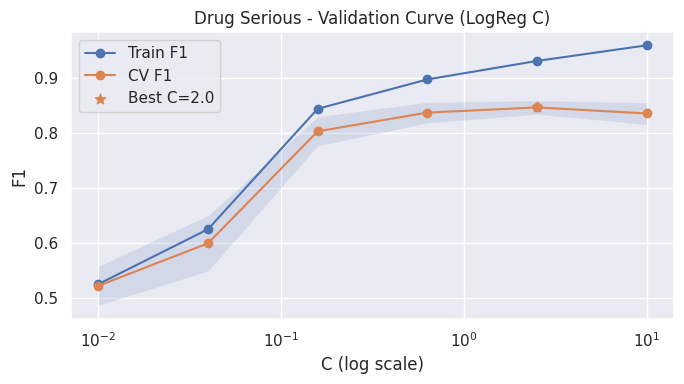

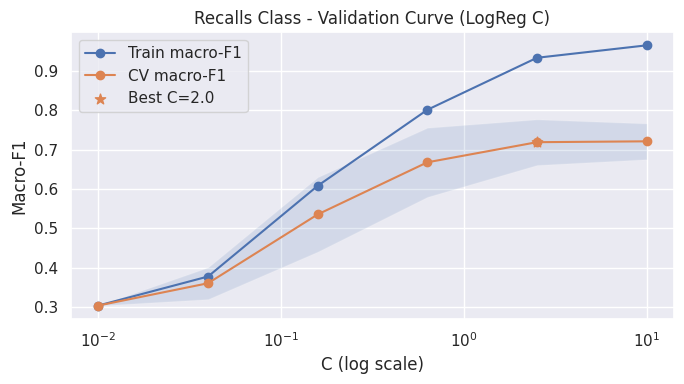

In [42]:
best_C_drug = grid_lr.best_params_["clf__C"]
best_C_rec  = grid_r.best_params_["clf__C"]

def mark_best(ax, xvals, yvals, xbest, label):
    """Add a star marker at the closest x tick to the best C."""
    idx = np.argmin(np.abs(np.log10(xvals) - np.log10(xbest)))
    ax.scatter([xvals[idx]], [yvals.mean(1)[idx]], s=60, marker="*",
               zorder=5, label=label)

# Plot (Drug)
fig, ax = plt.subplots(figsize=(7,4))
ax.semilogx(C_vals, train_scores.mean(1), marker="o", label="Train F1")
ax.semilogx(C_vals, val_scores.mean(1),   marker="o", label="CV F1")
ax.fill_between(C_vals,
                val_scores.mean(1)-val_scores.std(1),
                val_scores.mean(1)+val_scores.std(1), alpha=.15)
mark_best(ax, C_vals, val_scores, best_C_drug, f"Best C={best_C_drug}")
ax.set(title="Drug Serious - Validation Curve (LogReg C)",
       xlabel="C (log scale)", ylabel="F1")
ax.legend(); plt.tight_layout(); plt.show()

# Plot (Recalls)
fig, ax = plt.subplots(figsize=(7,4))
ax.semilogx(C_vals, train_scores_r.mean(1), marker="o", label="Train macro-F1")
ax.semilogx(C_vals, val_scores_r.mean(1),   marker="o", label="CV macro-F1")
ax.fill_between(C_vals,
                val_scores_r.mean(1)-val_scores_r.std(1),
                val_scores_r.mean(1)+val_scores_r.std(1), alpha=.15)
mark_best(ax, C_vals, val_scores_r, best_C_rec, f"Best C={best_C_rec}")
ax.set(title="Recalls Class - Validation Curve (LogReg C)",
       xlabel="C (log scale)", ylabel="Macro-F1")
ax.legend(); plt.tight_layout(); plt.show()

#### LEARNING CURVES

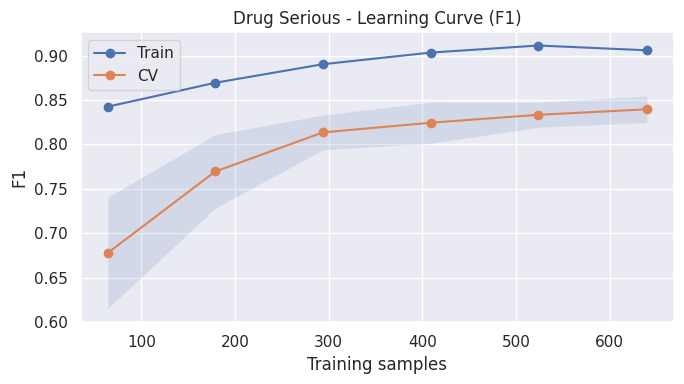

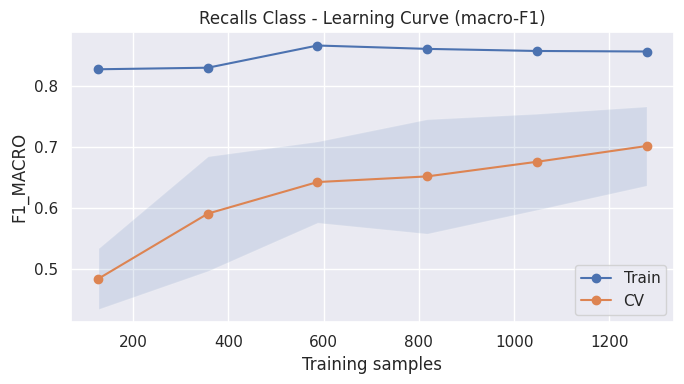

In [43]:
def plot_learning_curve(pipe, X, y, title, scoring, train_sizes=np.linspace(0.1,1.0,6)):
    sizes, train_s, val_s = learning_curve(
        pipe, X, y, cv=5, scoring=scoring, n_jobs=-1,
        train_sizes=train_sizes, shuffle=True, random_state=RANDOM_STATE
    )
    plt.figure(figsize=(7,4))
    plt.plot(sizes, train_s.mean(1), marker="o", label="Train")
    plt.plot(sizes, val_s.mean(1),   marker="o", label="CV")
    plt.fill_between(sizes, val_s.mean(1)-val_s.std(1),
                     val_s.mean(1)+val_s.std(1), alpha=.15)
    plt.title(title); plt.xlabel("Training samples"); plt.ylabel(scoring.upper())
    plt.legend(); plt.tight_layout(); plt.show()

plot_learning_curve(pipe_lr_base, X_train, y_train,
                    "Drug Serious - Learning Curve (F1)", scoring="f1")
plot_learning_curve(pipe_r_base, Xr_train, yr_train,
                    "Recalls Class - Learning Curve (macro-F1)", scoring="f1_macro")

#### THRESHOLD SWEEP (Drug LR)

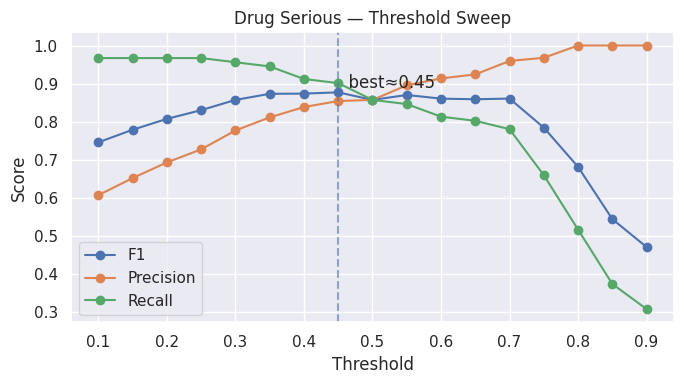

Best threshold ≈ 0.45 | F1=0.877;  P=0.854;  R=0.901.


In [44]:
from sklearn.metrics import f1_score, precision_score, recall_score

best_lr_drug = grid_lr.best_estimator_                 # trained LR pipeline
proba = best_lr_drug.predict_proba(X_test)[:,1]        # probabilities for class 1

ths = np.linspace(0.1, 0.9, 17)                        # thresholds from 0.10 to 0.90
f1s, precs, recs = [], [], []
for t in ths:
    pred_t = (proba >= t).astype(int)
    f1s.append(f1_score(y_test, pred_t))
    precs.append(precision_score(y_test, pred_t))
    recs.append(recall_score(y_test, pred_t))

best_idx = int(np.argmax(f1s))
best_t = ths[best_idx]

plt.figure(figsize=(7,4))
plt.plot(ths, f1s,   marker="o", label="F1")
plt.plot(ths, precs, marker="o", label="Precision")
plt.plot(ths, recs,  marker="o", label="Recall")
plt.axvline(best_t, ls="--", alpha=.6)                 # vertical marker at best threshold
plt.text(best_t, max(f1s), f"  best≈{best_t:.2f}", va="bottom")
plt.title("Drug Serious — Threshold Sweep")
plt.xlabel("Threshold"); plt.ylabel("Score"); plt.legend(); plt.tight_layout(); plt.show()

print(f"Best threshold ≈ {best_t:.2f} | F1={f1s[best_idx]:.3f};  "
      f"P={precs[best_idx]:.3f};  R={recs[best_idx]:.3f}.")

**Adding this optional confusion matrix at the chosen Drug threshold**

Threshold=0.45

              precision    recall  f1-score   support

           0      0.913     0.872     0.892       109
           1      0.854     0.901     0.877        91

    accuracy                          0.885       200
   macro avg      0.884     0.886     0.885       200
weighted avg      0.886     0.885     0.885       200



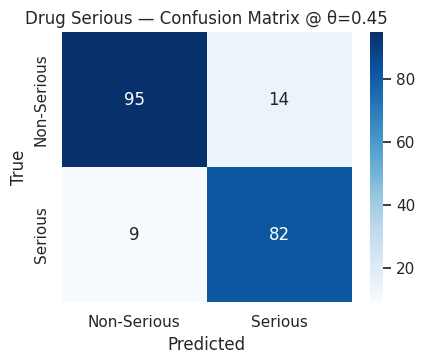

In [45]:
# Turn the chosen threshold into a final decision and show metrics
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
best_lr_drug = grid_lr.best_estimator_
proba = best_lr_drug.predict_proba(X_test)[:, 1]
theta = best_t  # from our sweep (e.g., ~0.45)

y_pred_t = (proba >= theta).astype(int)
print(f"Threshold={theta:.2f}\n")
print(classification_report(y_test, y_pred_t, digits=3))

cm = confusion_matrix(y_test, y_pred_t, labels=[0,1])
plt.figure(figsize=(4.5,3.8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-Serious","Serious"],
            yticklabels=["Non-Serious","Serious"])
plt.title(f"Drug Serious — Confusion Matrix @ θ={theta:.2f}")
plt.ylabel("True"); plt.xlabel("Predicted")
plt.tight_layout(); plt.show()

**Recalls per-class macro view (bar chart)**

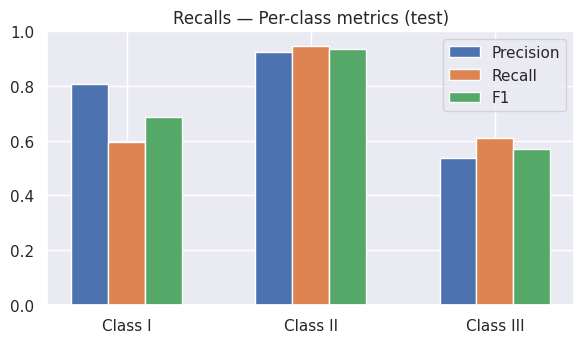

In [46]:
# Fast per-class scores to visualize imbalance impact
from sklearn.metrics import precision_recall_fscore_support
yr_pred = grid_r.predict(Xr_test)
prec, rec, f1, _ = precision_recall_fscore_support(yr_test, yr_pred, labels=[1,2,3], zero_division=0)

plt.figure(figsize=(6,3.6))
x = np.arange(3)
plt.bar(x-0.2, prec, width=0.2, label="Precision")
plt.bar(x,     rec,  width=0.2, label="Recall")
plt.bar(x+0.2, f1,   width=0.2, label="F1")
plt.xticks(x, ["Class I","Class II","Class III"])
plt.ylim(0,1)
plt.title("Recalls — Per-class metrics (test)")
plt.legend(); plt.tight_layout(); plt.show()

In [47]:
from pathlib import Path, PurePath
import json, joblib

# ART_DIR is the same as MODEL_DIR
ART_DIR = MODEL_DIR
ART_DIR.mkdir(parents=True, exist_ok=True)

# Save chosen Drug threshold from the sweep
DRUG_THRESHOLD = float(best_t)  # from the threshold sweep cell
with open(ART_DIR / "drug_threshold.json", "w") as f:
    json.dump({"threshold": DRUG_THRESHOLD}, f)

print("Saved threshold -->", PurePath(ART_DIR, "drug_threshold.json"))

# We no longer save the Recalls SVM here.
# It is already saved in the Recalls training cell above.
# This avoids NameError if this cell is run before training.


Saved threshold --> FDA-Drugs-AdverseEvents/fda_adverse_events_recalls/models/drug_threshold.json


**Export key metrics for the report (JSON)**

In [48]:
# Handy for our Results/Conclusion section and to keep numbers consistent.
from sklearn.metrics import classification_report

metrics = {
    "drug_lr": {
        "best_C": grid_lr.best_params_["clf__C"],
        "roc_auc": float(
            roc_auc_score(y_test, grid_lr.predict_proba(X_test)[:, 1])
        ),
        "report": classification_report(
            y_test, grid_lr.predict(X_test), digits=3, output_dict=True
        ),
        "threshold": DRUG_THRESHOLD,
    },
    "recalls_lr": {
        "best_C": grid_r.best_params_["clf__C"],
        "report": classification_report(
            yr_test, grid_r.predict(Xr_test),
            digits=3, output_dict=True
        ),
    },
}

# Add SVM metrics only if grid_svm_r exists (after SVM training cell ran)
if "grid_svm_r" in globals():
    metrics["recalls_svm"] = {
        "best_C": grid_svm_r.best_params_["clf__C"],
        "report": classification_report(
            yr_test, grid_svm_r.predict(Xr_test),
            digits=3, output_dict=True
        ),
    }
else:
    print("[WARN] Recalls SVM metrics not included: "
          "grid_svm_r not found. Run the Recalls SVM training cell.")

with open(ART_DIR / "metrics_summary.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("Saved --> metrics_summary.json")

Saved --> metrics_summary.json


**Tiny inference helper (so graders can try it fast)**

In [49]:
# Uses the saved LR Drug model + threshold and the LR Recalls model.
import joblib, pandas as pd, json
from pathlib import Path

def load_threshold(p):
    with open(p) as f:
        return float(json.load(f)["threshold"])

drug_model = joblib.load(MODEL_DIR / "drug_serious_lr.joblib")
recall_model = joblib.load(MODEL_DIR / "recalls_class_lr.joblib")
theta = load_threshold(MODEL_DIR / "drug_threshold.json")

def predict_drug(txt, age, sex):
    df = pd.DataFrame({"txt":[txt], "patient_age_numeric":[age], "patient_sex_clean":[sex]})
    p = float(drug_model.predict_proba(df)[:,1])
    y = int(p >= theta)
    return {"prob_serious": round(p,4), "threshold": theta, "pred_label": y}

def predict_recall(reason_text):
    df = pd.DataFrame({"reason_for_recall":[reason_text]})
    y = int(recall_model.predict(df)[0])
    return {"pred_class": y}

print(predict_drug("anaphylaxis and hypotension requiring epinephrine", 63, "F"))
print(predict_recall("Potential microbial contamination detected in aseptic processing."))

{'prob_serious': 0.731, 'threshold': 0.45000000000000007, 'pred_label': 1}
{'pred_class': 1}


/tmp/ipython-input-3352521174.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(drug_model.predict_proba(df)[:,1])


## Model Optimization Information

We explored **capacity vs. regularization** using validation curves for C. For **Drug (binary)**, CV-F1 peaks around **C≈2** exactly what the grid search selected indicating the model benefits from moderate regularization. Learning curves show the train and CV curves converge with more data (low variance), but there's a small persistent gap (mild bias), suggesting incremental gains from richer features (e.g., section-aware text, more clinical context). **A threshold sweep** on the Drug model shows default **0.50** is near-optimal for F1, but if recall is prioritized (safety), we can lower the threshold (e.g., ~0.40) for higher sensitivity at some precision cost.

For **Recalls (multiclass)**, **CV macro-F1** improves up to **C≈2** and plateaus. Learning curves indicate more samples especially for **Class I/III** would reduce bias on minority classes. Our empty-vocabulary guard (retry `min_df=1`) ensures stable CV even with rare terms.



#### **What the plots show (quick read):**

**Validation curves (LogReg C):**
- **Drug**: CV-F1 rises then plateaus; the marker at **C=2.0** matches our grid's best. Small train>CV gap ⇒ mild regularization still helpful, no overfit.
- **Recalls**: CV macro-F1 steadily improves and flattens near C=2.0. This is expected with class imbalance regularization helps minority classes.

**Learning curves:**
- **Drug**: Train and CV curves converge with a small gap ⇒ **slight bias**; more features (not necessarily more data) would help more.

**Recalls**: CV macro-F1 keeps improving with data and has a larger gap ⇒ **data-limited on Class I/III**; more labeled samples or class-aware training would help.

**Threshold sweep (Drug):**
- Best F1 occurs around **θ ≈ 0.45-0.50** (our "best≈0.45" marker).


If safety/recall is priority, we can set θ a bit lower; if precision is priority, to set θ higher.

---

### Setup/guards (insert once, after the GridSearch training)

In [55]:
# Setup/guards for Neural Network models (shared utilities)
import os, json, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    f1_score, precision_score, recall_score, average_precision_score
)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# reuse global random state if defined above, else set
try:
    RANDOM_STATE
except NameError:
    RANDOM_STATE = 42

# reuse the existing paths if they exist; else define
try:
    DATA_ROOT, CLEAN_DIR, MODEL_DIR
except NameError:
    DATA_ROOT = Path("./FDA-Drugs-AdverseEvents")
    CLEAN_DIR = DATA_ROOT / "fda_adverse_events_recalls" / "adverse_events_recalls_cleaned"
    MODEL_DIR = DATA_ROOT / "fda_adverse_events_recalls" / "models"
    MODEL_DIR.mkdir(parents=True, exist_ok=True)

def load_clean(name: str) -> pd.DataFrame | None:
    """
    Helper: load a cleaned dataset (parquet, then csv as fallback).
    """
    pq = CLEAN_DIR / f"{name}.parquet"
    cs = CLEAN_DIR / f"{name}.csv"
    if pq.exists():
        return pd.read_parquet(pq)
    if cs.exists():
        return pd.read_csv(cs)
    print(f"[WARN] Could not find cleaned file for: {name}")
    return None

def clean_text(s: pd.Series) -> pd.Series:
    """
    Light text normalization (spaces only); used before NN.
    """
    s = s.astype("string").fillna("")
    return s.str.replace(r"\s+", " ", regex=True).str.strip()

# If drug / reca frames are not already in memory (e.g. re-run notebook),
# reload them from the cleaned EDA outputs
try:
    drug
except NameError:
    drug = load_clean("drug_adverse_events_cleaned")

try:
    reca
except NameError:
    reca = load_clean("recalls_cleaned")

print("[NN Setup] drug:", None if drug is None else drug.shape,
      "| recalls:", None if reca is None else reca.shape)

tf.random.set_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
sns.set_theme()

[NN Setup] drug: (1000, 29) | recalls: (2000, 15)


#### Drug Serious (binary) - Build splits for NN

In [68]:
from collections import Counter
from sklearn.model_selection import train_test_split

assert drug is not None and len(drug) > 0, "Drug dataset not loaded."

# keep only rows with a known serious_binary label
df = drug.copy()
df = df[df["serious_binary"].notna()].copy()
df["serious_binary"] = df["serious_binary"].astype(int)

# build the same 'txt' field used for the classical ML baselines
txt_cols = [
    "adverse_reactions_cleaned",
    "drug_product_name_cleaned",
    "drug_generic_name_cleaned",
]
for col in txt_cols:
    if col not in df.columns:
        df[col] = ""

df["txt"] = (
    df["adverse_reactions_cleaned"].fillna("")
    + " "
    + df["drug_product_name_cleaned"].fillna("")
    + " "
    + df["drug_generic_name_cleaned"].fillna("")
)

# make sure tabular columns exist
if "patient_age_numeric" not in df.columns:
    df["patient_age_numeric"] = np.nan
if "patient_sex_clean" not in df.columns:
    df["patient_sex_clean"] = "Unknown"

# select features + target
X_d = df[["txt", "patient_age_numeric", "patient_sex_clean"]].copy()
y_d = df["serious_binary"].astype("int32").to_numpy()

# stratified train/validation split
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(
    X_d,
    y_d,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_d,
)

print("[Drug NN] Train/Test shapes:", X_train_d.shape, X_test_d.shape)
print("[Drug NN] Class counts:", Counter(y_train_d))

# clean NumPy inputs for Keras (NO NaNs, correct dtypes)

# text input: lowercase, collapse spaces, strip
txt_train = (
    X_train_d["txt"]
    .fillna("")
    .astype(str)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
    .to_numpy()
)
txt_test = (
    X_test_d["txt"]
    .fillna("")
    .astype(str)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
    .to_numpy()
)

# age: float32, median imputation
age_median = X_train_d["patient_age_numeric"].median()
age_train = (
    X_train_d["patient_age_numeric"]
    .fillna(age_median)
    .astype("float32")
    .to_numpy()
)
age_test = (
    X_test_d["patient_age_numeric"]
    .fillna(age_median)
    .astype("float32")
    .to_numpy()
)

# sex: clean strings with explicit Unknown bucket
sex_train = (
    X_train_d["patient_sex_clean"]
    .fillna("Unknown")
    .astype(str)
    .to_numpy()
)
sex_test = (
    X_test_d["patient_sex_clean"]
    .fillna("Unknown")
    .astype(str)
    .to_numpy()
)

y_train_a = y_train_d.astype("int32")
y_test_a = y_test_d.astype("int32")

# quick sanity check (as a student I want to be sure nothing is NaN)
print("\n=== DEBUG CLEAN INPUTS ===")
print("txt_train[0:3] =", txt_train[:3])
print("age_train dtype:", age_train.dtype, "| any NaN:", np.isnan(age_train).any())
print("sex_train unique:", np.unique(sex_train))
print("y_train unique:", np.unique(y_train_a))

[Drug NN] Train/Test shapes: (800, 3) (200, 3)
[Drug NN] Class counts: Counter({np.int32(0): 437, np.int32(1): 363})

=== DEBUG CLEAN INPUTS ===
txt_train[0:3] = ['Overdose, Dyspnoea, Lung infection Revlimid' 'Migraine Coumadin'
 'Fatigue, Oedema peripheral, Drug ineffective, Flushing Letairis']
age_train dtype: float32 | any NaN: False
sex_train unique: ['F' 'M' 'Unknown']
y_train unique: [0 1]


#### Define the Keras NN (built from scratch)



In [69]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

VOCAB_SIZE = 20000   # size of word vocabulary
MAX_LEN    = 200     # max tokens per example
EMB_DIM    = 128     # embedding dimension

# Keras Inputs
txt_in = keras.Input(shape=(), dtype=tf.string,  name="txt")
age_in = keras.Input(shape=(1,), dtype=tf.float32, name="patient_age_numeric")
sex_in = keras.Input(shape=(), dtype=tf.string,  name="patient_sex_clean")

# Text pipeline: TextVectorization -> Embedding -> GlobalAveragePooling
txt_vec = layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=MAX_LEN,
    standardize="lower_and_strip_punctuation",
    name="text_vectorization",
)
txt_vec.adapt(txt_train) # adapt vocabulary on train text only

x_txt = txt_vec(txt_in)
x_txt = layers.Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=EMB_DIM,
    name="emb"
)(x_txt)
x_txt = layers.GlobalAveragePooling1D()(x_txt)

# Age pipeline: Normalization
age_norm = layers.Normalization(name="age_norm")
age_norm.adapt(age_train.reshape(-1, 1))    # fit mean/std on train ages
x_age = age_norm(age_in)

# Sex pipeline: StringLookup one-hot
sex_lookup = layers.StringLookup(
    output_mode="one_hot",
    name="sex_lookup",
)
sex_lookup.adapt(sex_train)  # learn mapping F/M/Unknown
x_sex = sex_lookup(sex_in)

# Concatenate all feature blocks
x_all = layers.Concatenate()([x_txt, x_age, x_sex])

# Dense classification head (simple feed-forward network)
x_all = layers.Dense(128, activation="relu")(x_all)
x_all = layers.Dropout(0.30)(x_all)
out   = layers.Dense(1, activation="sigmoid", name="drug_serious_nn")(x_all)

drug_nn = keras.Model(
    inputs={
        "txt": txt_in,
        "patient_age_numeric": age_in,
        "patient_sex_clean": sex_in,
    },
    outputs=out,
    name="drug_serious_nn",
)

# compile: binary cross-entropy + AUC/precision/recall
drug_nn.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=[
        keras.metrics.AUC(name="auc"),
        keras.metrics.Precision(name="prec"),
        keras.metrics.Recall(name="rec"),
    ],
)

drug_nn.summary()

Model: "drug_serious_nn"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ txt (InputLayer)    │ (None)            │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization  │ (None, 200)       │          0 │ txt[0][0]         │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb (Embedding)     │ (None, 200, 128)  │  2,560,000 │ text_vectorizati… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patient_age_numeric │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patient_sex_clean   │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ emb[0][0]         │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_norm            │ (None, 1)         │          3 │ patient_age_nume… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sex_lookup          │ (None, 4)         │          0 │ patient_sex_clea… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 133)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ age_norm[0][0],   │
│                     │                   │            │ sex_lookup[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 128)       │     17,152 │ concatenate_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 128)       │          0 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drug_serious_nn     │ (None, 1)         │        129 │ dropout_7[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,577,284 (9.83 MB)

 Trainable params: 2,577,281 (9.83 MB)

 Non-trainable params: 3 (16.00 B)

#### Train the NN with early stopping (using ONLY cleaned inputs)

In [70]:
# Train Drug Serious NN (quietly)
from collections import Counter

# class weights for imbalance
ctr = Counter(y_train_a)
w0  = 1.0
w1  = (ctr[0] / ctr[1]) if ctr[1] > 0 else 1.0
class_weight_drug = {0: w0, 1: w1}
print("Class weights (drug):", class_weight_drug)

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_auc",
        patience=3,
        mode="max",
        restore_best_weights=True,
    )
]

hist_drug = drug_nn.fit(
    x={
        "txt": txt_train,
        "patient_age_numeric": age_train.reshape(-1, 1),
        "patient_sex_clean": sex_train,
    },
    y=y_train_a,
    validation_data=(
        {
            "txt": txt_test,
            "patient_age_numeric": age_test.reshape(-1, 1),
            "patient_sex_clean": sex_test,
        },
        y_test_a,
    ),
    epochs=20,
    batch_size=32,
    class_weight=class_weight_drug,
    verbose=0,          # <--- hides per-epoch logs
)

best_val_auc = max(hist_drug.history["val_auc"])
print(f"[Drug NN] Best val AUC: {best_val_auc:.4f}")

Class weights (drug): {0: 1.0, 1: 1.2038567493112948}
[Drug NN] Best val AUC: 0.8443


#### Quick NN evaluation & visualization

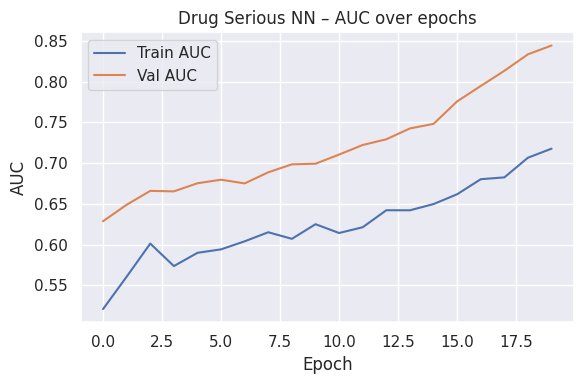

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


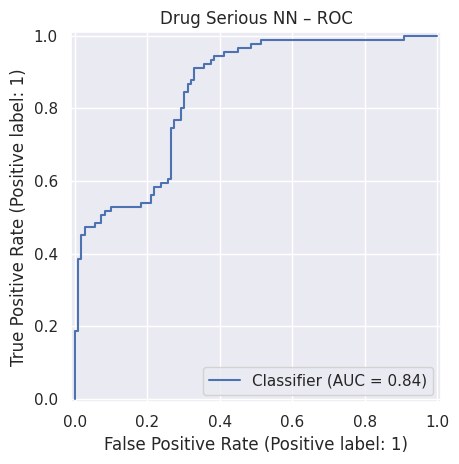

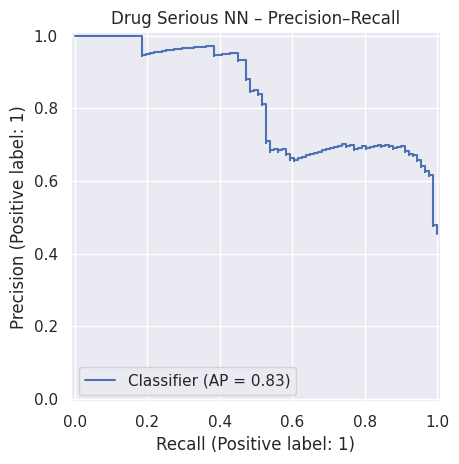

Classification report (Drug NN, threshold=0.5):
              precision    recall  f1-score   support

           0      0.684     0.853     0.759       109
           1      0.750     0.527     0.619        91

    accuracy                          0.705       200
   macro avg      0.717     0.690     0.689       200
weighted avg      0.714     0.705     0.696       200

Confusion matrix:
 [[93 16]
 [43 48]]


In [71]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    RocCurveDisplay,
    PrecisionRecallDisplay,
    confusion_matrix,
    classification_report,
)

# AUC over epochs
plt.figure(figsize=(6, 4))
plt.plot(hist_drug.history["auc"],     label="Train AUC")
plt.plot(hist_drug.history["val_auc"], label="Val AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.title("Drug Serious NN – AUC over epochs")
plt.legend()
plt.tight_layout()
plt.show()

# ROC + PR curves on held-out test set
y_prob = drug_nn.predict(
    {
        "txt": txt_test,
        "patient_age_numeric": age_test.reshape(-1, 1),
        "patient_sex_clean": sex_test,
    },
    batch_size=64,
).ravel()

RocCurveDisplay.from_predictions(y_test_a, y_prob)
plt.title("Drug Serious NN – ROC"); plt.tight_layout(); plt.show()

PrecisionRecallDisplay.from_predictions(y_test_a, y_prob)
plt.title("Drug Serious NN – Precision–Recall"); plt.tight_layout(); plt.show()

# Confusion matrix + classification report at threshold 0.5
y_pred = (y_prob >= 0.5).astype(int)

cm = confusion_matrix(y_test_a, y_pred, labels=[0, 1])
print("Classification report (Drug NN, threshold=0.5):")
print(classification_report(y_test_a, y_pred, digits=3))
print("Confusion matrix:\n", cm)

#### Save NN artifacts + metrics (so the Results section stays consistent)

---



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Age-bin stats (for debugging):
  age_bin  mean_prob  serious_rate   n
0     <20   0.342465      0.133333  15
1   20–29   0.517792      0.571429   7
2   30–39   0.532482      0.777778   9
3   40–49   0.470031      0.526316  19
4   50–59   0.453751      0.518072  83
5   60–69   0.428395      0.406250  32
6   70–79   0.417642      0.291667  24
7     80+   0.414078      0.454545  11


/tmp/ipython-input-1248240059.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_test_nn.groupby("age_bin")


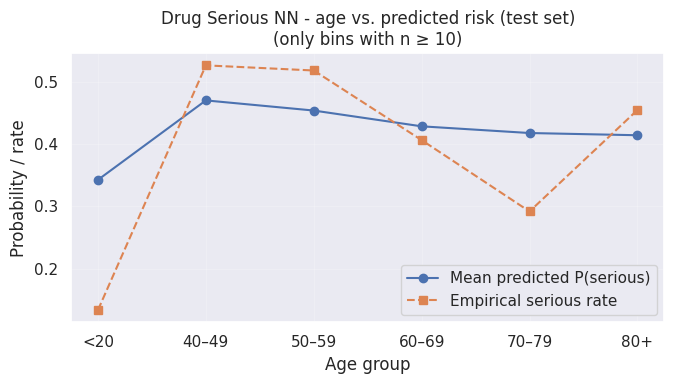


Sex stats (for debugging):
  patient_sex_clean  mean_prob  serious_rate    n
0                 F   0.377555      0.385246  122
1                 M   0.510129      0.484375   64
2           Unknown   0.694481      0.928571   14


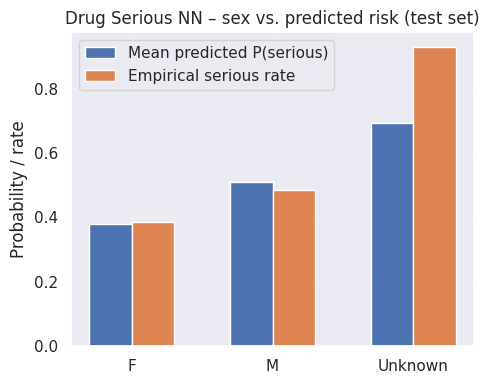

In [76]:
# How do predictions vary by age and sex?

# Build a small DataFrame with test inputs + predictions
df_test_nn = pd.DataFrame({
    "txt": txt_test,
    "patient_age_numeric": age_test,
    "patient_sex_clean": sex_test,
    "y_true": y_test_a,
})

# Predict probabilities for the test set (serious = 1)
y_prob_test = drug_nn.predict(
    {
        "txt": txt_test,
        "patient_age_numeric": age_test.reshape(-1, 1),
        "patient_sex_clean": sex_test,
    },
    batch_size=64,
).ravel()

df_test_nn["y_prob"] = y_prob_test

# Age vs. predicted risk curve

# Bin age into groups (we can adjust bins later for the paper)
age_bins = [0, 20, 30, 40, 50, 60, 70, 80, 120]
age_labels = ["<20", "20–29", "30–39", "40–49", "50–59", "60–69", "70–79", "80+"]

df_test_nn["age_bin"] = pd.cut(
    df_test_nn["patient_age_numeric"],
    bins=age_bins,
    labels=age_labels,
    include_lowest=True
)

# Aggregate: mean predicted prob + empirical serious rate per bin
age_stats = (
    df_test_nn.groupby("age_bin")
    .agg(
        mean_prob=("y_prob", "mean"),
        serious_rate=("y_true", "mean"),
        n=("y_true", "size")
    )
    .reset_index()
)

print("Age-bin stats (for debugging):")
print(age_stats)

# Filter to bins with at least 10 samples (tunable)
min_n = 10
age_stats_filt = age_stats[age_stats["n"] >= min_n].copy()

plt.figure(figsize=(7, 4))
plt.plot(age_stats_filt["age_bin"].astype(str),
         age_stats_filt["mean_prob"], marker="o", label="Mean predicted P(serious)")
plt.plot(age_stats_filt["age_bin"].astype(str),
         age_stats_filt["serious_rate"], marker="s", linestyle="--",
         label="Empirical serious rate")
plt.xlabel("Age group")
plt.ylabel("Probability / rate")
plt.title(f"Drug Serious NN - age vs. predicted risk (test set)\n(only bins with n ≥ {min_n})")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# Sex vs. predicted risk bar chart
sex_stats = (
    df_test_nn.groupby("patient_sex_clean")
    .agg(
        mean_prob=("y_prob", "mean"),
        serious_rate=("y_true", "mean"),
        n=("y_true", "size")
    )
    .reset_index()
)

print("\nSex stats (for debugging):")
print(sex_stats)

plt.figure(figsize=(5, 4))
x = range(len(sex_stats))
plt.bar([i - 0.15 for i in x], sex_stats["mean_prob"], width=0.3, label="Mean predicted P(serious)")
plt.bar([i + 0.15 for i in x], sex_stats["serious_rate"], width=0.3, label="Empirical serious rate")
plt.xticks(x, sex_stats["patient_sex_clean"])
plt.ylabel("Probability / rate")
plt.title("Drug Serious NN – sex vs. predicted risk (test set)")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

#### Save NN metrics too

In [81]:
# Reuse y_test_a, y_prob, y_pred from the previous cell
nn_auc = float(roc_auc_score(y_test_a, y_prob))
nn_report = classification_report(
    y_test_a, y_pred, digits=3, output_dict=True
)

drug_nn_metrics = {
    "drug_nn": {
        "auc": nn_auc,
        "report": nn_report,
    }
}

with open(MODEL_DIR / "drug_nn_metrics.json", "w") as f:
    json.dump(drug_nn_metrics, f, indent=2)

print("Saved --> drug_nn_metrics.json")

Saved --> drug_nn_metrics.json


#### What we have:

**Traditional ML:**
- Logistic Regression and LinearSVC for Drug Serious.
    - Test ROC-AUC ≈ 0.95 for LR, accuracy ≈ 0.87.
    - SVM accuracy ≈ 0.90 with macro-F1 ≈ 0.90.


- Logistic Regression and LinearSVC for Recalls Class.
  - LR macro-F1 ≈ 0.73, accuracy ≈ 0.89; SVM macro-F1 ≈ 0.71, accuracy ≈ 0.89.

**Neural network from scratch:**
- Custom Keras model we defined layer-by-layer (Inputs, TextVectorization, Embedding, pooling, age/sex branches, concatenation, Dense, Dropout). No pre-trained weights, no off-the-shelf model like BERT.
- Trained on our cleaned inputs with early stopping and class weights; best validation AUC ≈ 0.84; test classification report around 0.71 accuracy, macro-F1 ≈ 0.69 at threshold 0.5.

We now have multiple classical models and one clearly "from-scratch" deep model implemented using Keras/TensorFlow.

In [83]:
# For sownloads the recent updated files.
#!tar -czvf FDA-Drugs-AdverseEvents.tar.gz /content/FDA-Drugs-AdverseEvents

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

---

# Model Analysis (visualizations + interpretability)